In [ ]:
import os
import random
import copy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
import torch
import time
import datetime
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

seed = 449
random.seed(seed)
torch.manual_seed(seed)
writer = SummaryWriter(flush_secs=20)

#in cmd: tensorboard --logdir runs
#http://localhost:6006/#

Files already downloaded and verified
Files already downloaded and verified


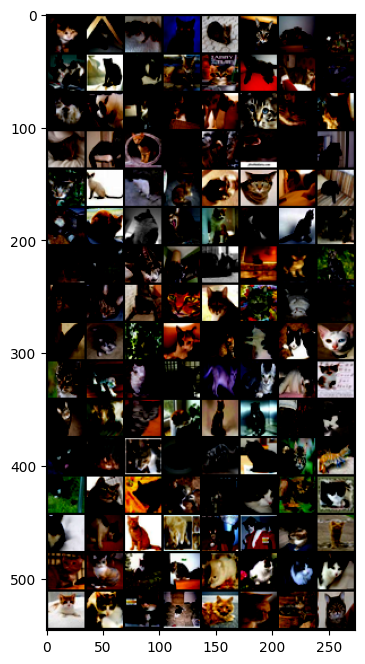

In [ ]:
from torchvision.transforms.autoaugment import TrivialAugmentWide
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# trainset = torch.utils.data.ConcatDataset([trainset, testset])

cat_idxs = np.where((np.array(trainset.targets) == 3))[0]
catset = torch.utils.data.Subset(trainset, cat_idxs)
catloader = torch.utils.data.DataLoader(catset, batch_size=batch_size, shuffle=True, num_workers=2)

# functions to show an image
def imshow(img, title=""):
    #img = img / 2 + 0.5     # unnormalize
    img = img.numpy()
    plt.figure(figsize=(8,8))
    plt.title(title)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
def imsave(img, path):
    img = img / 2 + 0.5
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    path = path + "-image.png"
    plt.imsave(path, img)

dataiter = iter(catloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

# Forward Process

In [ ]:
class diffusion_process(nn.Module):
    
    def __init__(self, time_steps, beta_1, beta_T):
        super().__init__()
        """
        beta_1 and beta_T are the variances for q(x_1|x_0) and q(x_T|x_{T-1}) respectively
        beta_T should be larger, and we'll linearly interpolate between these to set the variances of the diffusion process.
        """
        
        self.variance_schedule = torch.linspace(beta_1, beta_T, time_steps)   #could be learned (Kingma et al), but we'll start with fixed.
        self.T = time_steps
        
        
    def forward_var(self, t):
        """
        The variance schedule records the variances of q(x_{t}| x_{t-1}) - this returns the variance of q(x_t| x_0)
        where both x_0 and t are batches rather than an isolated datapoint.
        """
        ones = torch.ones(self.variance_schedule.size()) 
        alphas = ones - self.variance_schedule
        alpha_bars = torch.cumprod(alphas, dim=0)

        return 1- alpha_bars[t]
        
        
        
    def forward(self, x, t):
        """
        starting with an input batch of images x and a timestep t between 0 and 1, we return a sample x_{t} from q(x_t | x) and the corresponding log probability.
        We'll always work in closed form rather than performing a sequence of samples.
        """

        var = self.forward_var(t).view(-1,1,1,1)
        sqrt_var = torch.sqrt(var)
        alpha_bar = torch.sqrt(1-var)
        
        epsilon = torch.randn_like(x)
        x_t = alpha_bar*x + sqrt_var*epsilon

        return x_t, epsilon
    

# Small UNet


This is adapted from the implementation at https://github.com/dome272/Diffusion-Models-pytorch. The architecture has been updated to shrink the number of trainable parameters from ~23 million to ~3 million.


In [ ]:
class denoise_net(nn.Module):
  """
  This class basically organizes some utilities we'll use in the backward process. It doesn't include anything of import about the UNET.
  """
  def __init__(self, dif_proc, net):
      super().__init__()
      self.dif_proc = dif_proc
      self.net = net
        
  def forward(self, z_t, t):
      #should take in a pair (z_t, t) and spit out epsilon(z_t, t)
      #epsilon should be a U-net neural network, as in Ho et al.
      return self.net(z_t, t)
        
  def denoise(self, z_t, t):
      #should take in a pair (z_t, t) and spit out the neural networks reconstruction of x from z_t
      var_t = self.dif_proc.forward_var(t) #Equation 3
      alpha_t = (1-var_t)**.5
                
      return (z_t - var_t*self.net(z_t,t))/alpha_t #Equation 10

In [ ]:
"""
Here are all the basic layer types used in the UNet. These are directly copied from https://github.com/dome272/Diffusion-Models-pytorch.
We probably don't need to change these.
The input parameters to these layers are usually such that each layer acts on an input of size BxCxHxW as depicted below:

SelfAttention: BxCxHxW -> BxCxHxW (preservers dimension with appropriate setup)

DoubleConv: B x C_in x H x W -> B x C_out x H x W (preserves dimensions other than channels)

Down: B x C_in x H x W -> B x C_out x H/2 x W/2 (divides spatial dimensions by 2, acts on channels as indicated)

Up: B x C_in x H x W -> B x C_out x 2H x 2W.    (multiplies spatial dimensions by 2, acts on channels as indicated)
"""


class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

In [ ]:
class SmallUNet(nn.Module):
  """
  Implements a UNet with 2 downsamples and 2 upsamples (instead of 3), and time-embedding following https://github.com/dome272/Diffusion-Models-pytorch.
  Architecture is setup for CIFAR10 images.
  """
  def __init__(self, c_in=3, c_out=3, time_dim=256, device="cpu"):
      super().__init__()
      self.device = device
      self.time_dim = time_dim
      self.inc = DoubleConv(c_in, 32)
      self.down1 = Down(32, 64)
      self.sa1 = SelfAttention(64, 16)  
      self.down2 = Down(64, 128)
      self.sa2 = SelfAttention(128, 8)

      self.bot1 = DoubleConv(128, 256)
      self.bot2 = DoubleConv(256, 128)

      self.up1 = Up(192, 64)
      self.sa4 = SelfAttention(64, 16)
      self.up2 = Up(96, 64)
      self.outc = nn.Conv2d(64, c_out, kernel_size=1)

  def pos_encoding(self, t, channels):
      inv_freq = 1.0 / (
          10000
          ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
      )

      inv_freq = inv_freq.to(self.device) #should be unnecessary, but I'm running into problems
      t = t.to(self.device)

      pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
      pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
      pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
      return pos_enc

  def forward(self, x, t):
      t = t.unsqueeze(-1).type(torch.float)
      t = self.pos_encoding(t, self.time_dim)

      x1 = self.inc(x)       
      x2 = self.down1(x1, t)    
      x2 = self.sa1(x2)            
      x3 = self.down2(x2, t)       

        
      x3 = self.sa2(x3)
      x3 = self.bot1(x3)
      x3 = self.bot2(x3)

      x = self.up1(x3, x2, t)        
      x = self.sa4(x)        
      x = self.up2(x, x1, t)
        
      output = self.outc(x)
      return output

In [ ]:
class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 16)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 8)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 4)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 8)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 16)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 32)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        inv_freq = inv_freq.to(self.device)
        t = t.to(self.device)
        
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

# Utilities for the diffusion model

In [ ]:
class diff_model:
    
    def __init__(self, dif_proc, denoiser, prior, device = "cuda"):
        super().__init__()
        
        self.device = device
        self.prior = prior
        self.dif_proc = dif_proc
        self.denoiser = denoiser 
        self.T = dif_proc.T
        
    
    def generate(self, batch_size=64):
        """
        This function generates a batch of images following algorithm 2 from Ho et al.
        """
        with torch.no_grad():
          im = torch.randn((batch_size, 3, 32, 32)).to(self.device)
    
          for i in reversed(range(self.T)):
            if i > 1:
              z = torch.randn_like(im).to(self.device)
            else:
              z = torch.zeros(im.size()).to(self.device)
            t = (torch.ones(batch_size)*i).long()
            alpha = (1 - self.dif_proc.variance_schedule[t]).view(-1,1,1,1).to(self.device)
            alpha_bar = (1 - self.dif_proc.forward_var(t)).view(-1,1,1,1).to(self.device)
            sigma = torch.sqrt(1-alpha) #this is a choice - see section 3.2 of Ho et al

            im = 1/torch.sqrt(alpha)*(im - ((1-alpha)/torch.sqrt(1-alpha_bar))*self.denoiser.net(im, t)) + sigma*z

          im = (torch.clamp(im, -1, 1)+1)/2
          im = (im*255).type(torch.uint8)
    
          return im
        
        
        
        
    def gaussian_kl(self, mean_1, logvar_1, mean_2, logvar_2, reduction = None):
        """
        Given two Gaussian distributions p_1 and p_2, returns D_{KL}(p_1 || p_2)
        """
       
        D = 0.5 * (-1.0 + logvar_2 - logvar_1 + torch.exp(logvar_1 - logvar_2)
            + ((mean_1-mean_2)**2) * torch.exp(-logvar_2))
        
        if reduction:
            return torch.sum(D)
        else:
            return D
        
        
        
        
        
    def posterior_parameters(self, x_0, x_t, t):
        """
        returns the mean and log-variance of q(x_{t-1} | x_t, x_0) according to equation (7) in Ho et al
        """
        beta_t = self.dif_proc.variance_schedule[t]
        alpha_t = 1-beta_t
        
        alpha_bar_t = 1-self.dif_proc.forward_var(t)
        alpha_bar_s = 1-self.dif_proc.forward_var(t-1)
        
        coef_1 = (alpha_bar_s**.5)*beta_t/(1-alpha_bar_t)
        
        coef_2 = (alpha_t**.5)*(1-alpha_bar_s)/(1-alpha_bar_t)
        
        mean = coef_1*x_0 + coef_2*x_t
        var = (1-alpha_bar_s)/(1-alpha_bar_t)*beta_t
        
        return mean, torch.log(var)
        
        
              
        
    def model_distribution_parameters(self, x_t, t):
        """
        returns the mean and log-variance of p(x_{t-1}|x_{t}) according to equation (11) for the mean, and the choice of sigma^2_{t} = beta_{t} as in
        the first paragraph of 3.2
        """
        
        beta_t = self.dif_proc.variance_schedule[t]
        alpha_bar_t = 1- self.dif_proc.forward_var(t)
        
        epsilon_theta = self.denoiser(x_t, t)
        
        mean = (1/(1-beta_t)**.5)*(x_t - beta_t/((1-alpha_bar_t)**.5)*epsilon_theta)
        
        return mean, torch.log(beta_t)
        
              
        
    def L_t(self, x_0, x_t, t):
        """
        Given a clean image x_0 and a noisy version x_t, return D_{KL}(q(x_{t-1}| x_t, x_0) || p(x_{t-1}|x_t)), or ||eps - eps_theta||^2
        """

        mu_q, logvar_q = self.posterior_parameters(x_0, x_t, t)       
        mu_p, logvar_p = self.model_distribution_parameters(x_t, t)
        
        return self.gaussian_kl(mu_q, logvar_q, mu_p, logvar_p, reduction = True)
    
    
        

# Training

In [ ]:
batch_size = 128
image_size = 32

#number of time steps in diffusion process
T = 1000

#beta schedule for the forward process
beta_0 = .0001
beta_T = .02

#beta for optimizer
beta1 = 0.9

num_epochs = 500
lr = 0.0003
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

path = "models/" + "1000" + "ep_" + str(beta_0) + str(beta_T) + "betas" + str(T) + "T_" +"SmallUNet"


catloader = torch.utils.data.DataLoader(catset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
#Initialize the model

small_net = SmallUNet(device = device)
small_net.load_state_dict(torch.load("experiment_3.pth"))

dif_proc = diffusion_process(T, beta_0, beta_T)
denoising_net = denoise_net(dif_proc, small_net)

def prior(size):
  """
  just samples from a Gaussian, though in theory could be something different
  """
  z = torch.randn(size)
  return z


model = diff_model(dif_proc, denoising_net, prior([1,3,32,32]), device = device)
model.denoiser.net.to(device)
optimizer = torch.optim.Adam(denoising_net.net.parameters(), lr=lr, betas=(beta1, 0.999))

#setup the tensorboard
run_time = datetime.datetime.now().strftime("%I:%M%p on %B %d, %Y")






In [ ]:
"""
The training loop.
"""
def train(epochs, dataloader, opt, model):
  tot_loss = torch.zeros(epochs).to(device)
  img_list = []
  model.denoiser.net.train()
  mse = torch.nn.MSELoss()
    
  start_time = time.time()

  for i in range(epochs):
    for batch, _ in dataloader:
      batch_size = batch.size(0)
      t = torch.randint(1, model.T, (batch_size,))
      x_t, eps = model.dif_proc(batch, t)

      t = t.to(device)
      x_t = x_t.to(device)
      eps = eps.to(device)
                     
      opt.zero_grad()
      loss = mse(eps, model.denoiser.net(x_t, t))
      loss.backward()
      opt.step()
      tot_loss[i] += loss.detach()

      #tracking stats in tensorboard
      if i%1 == 0:
        writer.add_scalar("loss", tot_loss[i], i)
        
    print("epoch = {} loss={:.6f}".format(i, tot_loss[i]))
  writer.flush()
  writer.close()

  model.denoiser.net.eval()
  #os.makedirs("models")
  torch.save(model.denoiser.net.state_dict(), path)





In [ ]:
train(num_epochs, catloader, optimizer, model)

epoch = 0 loss=1.073481
epoch = 1 loss=1.044433
epoch = 2 loss=0.996928
epoch = 3 loss=1.059742
epoch = 4 loss=1.094589
epoch = 5 loss=1.078147
epoch = 6 loss=1.048074
epoch = 7 loss=1.152531
epoch = 8 loss=1.063627
epoch = 9 loss=1.102319
epoch = 10 loss=1.020308
epoch = 11 loss=1.091882
epoch = 12 loss=1.065027
epoch = 13 loss=1.055158
epoch = 14 loss=1.032663
epoch = 15 loss=1.059797
epoch = 16 loss=1.047463
epoch = 17 loss=1.014945
epoch = 18 loss=1.076623
epoch = 19 loss=1.055344
epoch = 20 loss=1.011862
epoch = 21 loss=1.040917
epoch = 22 loss=1.082521
epoch = 23 loss=1.116057
epoch = 24 loss=1.085174
epoch = 25 loss=1.010161
epoch = 26 loss=1.080034
epoch = 27 loss=1.079573
epoch = 28 loss=1.037788
epoch = 29 loss=1.082373
epoch = 30 loss=1.056561
epoch = 31 loss=1.091615
epoch = 32 loss=0.998727
epoch = 33 loss=1.058579
epoch = 34 loss=1.078232
epoch = 35 loss=1.045161
epoch = 36 loss=1.066202
epoch = 37 loss=1.045057
epoch = 38 loss=1.095313
epoch = 39 loss=1.059154
epoch = 40

In [ ]:
#os.makedirs("models")
#path = "experiment_3"
#torch.save(model.denoiser.net.state_dict(), path)

small_net = SmallUNet(device = device)
small_net.load_state_dict(torch.load("experiment_2.pth"))


<All keys matched successfully>

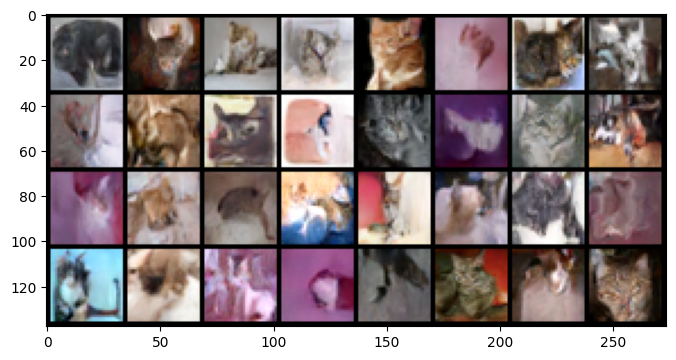

In [ ]:
loaded_denoising_net = denoise_net(dif_proc, small_net)
loaded_model = diff_model(dif_proc, loaded_denoising_net, prior([1,3,32,32]), device = device)
loaded_model.denoiser.net.to(device)

sampled_images = loaded_model.generate(32)



imshow(torchvision.utils.make_grid(sampled_images.cpu()))




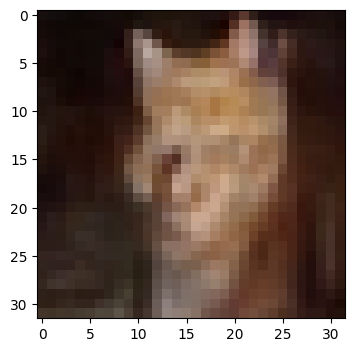

In [ ]:
im = sampled_images[8]
im = im.cpu().squeeze()
im = im.numpy()
plt.figure(figsize=(4,4))
plt.imshow(np.transpose(im, (1, 2, 0)))

plt.show()

In [ ]:
im_path = "experiment_2.png"
#os.makedirs("images")
normalized_images = sampled_images/255
torchvision.utils.save_image(normalized_images, im_path)
